# Классификация изображений Simpsons

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.


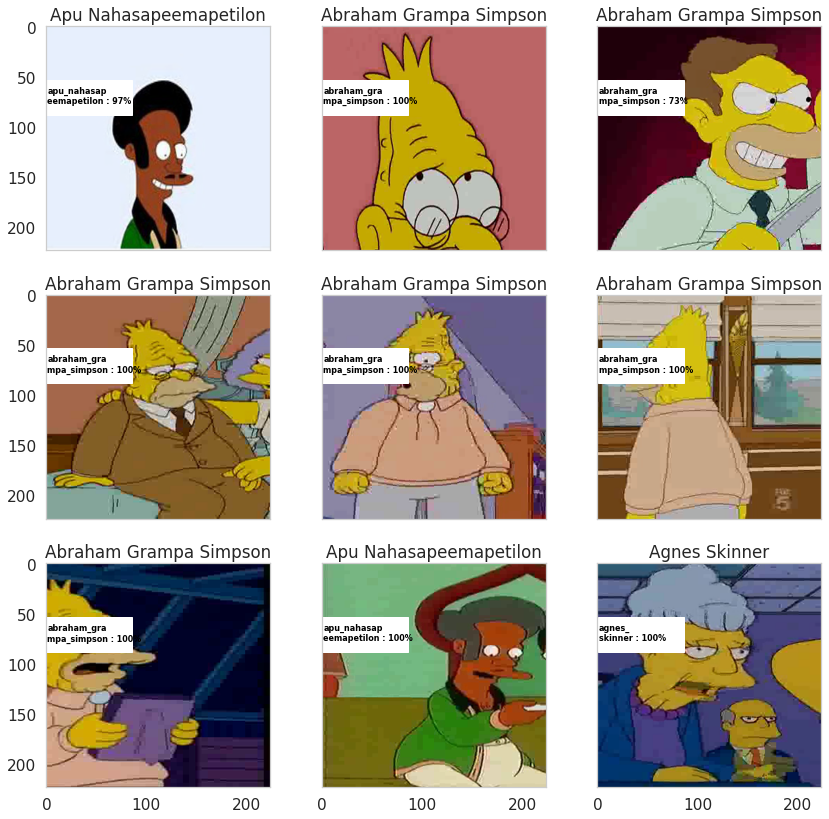

In [ ]:
import torch
import numpy as np
import PIL
print(PIL.__version__)


train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
    
import pickle
import pandas as pd
from collections import Counter
from skimage import io


import time

from tqdm.autonotebook import tqdm, trange # полоска прогресса

import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.model_selection import train_test_split

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import torchvision
from torchvision import transforms, models, datasets
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler


from functools import partial
from torch.nn import functional as F

from sklearn.metrics import f1_score

import torch.nn as nn
import seaborn as sns
from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

warnings.filterwarnings('ignore')    

9.1.1
CUDA is available!  Training on GPU ...


In [ ]:
!nvidia-smi
torch.cuda.is_available()

Wed Nov 23 23:04:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

# работаем на видеокарте
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Размер батча
batch_size=32


In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
# Директории
TRAIN_DIR = Path('../input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('../input/journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))


# Получим лэблы для тренировочной/валидационных выборок
train_val_labels = [path.parent.name for path in train_val_files]

# Разделим выборку с учётом дисбаланса классов
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels, random_state=12345)

# Получим лэйблы для тренивочных и валидационных выборок
train_labels, val_labels = [path.parent.name for path in train_files], [path.parent.name for path in val_files]

In [ ]:
# Посмотрим на длину тренировочного и валидационного датасетов
print(len(train_labels), len(val_labels))

15699 5234


* Размер тренировочной выборки позволяет использовать готовую архитектуру для Finetune.

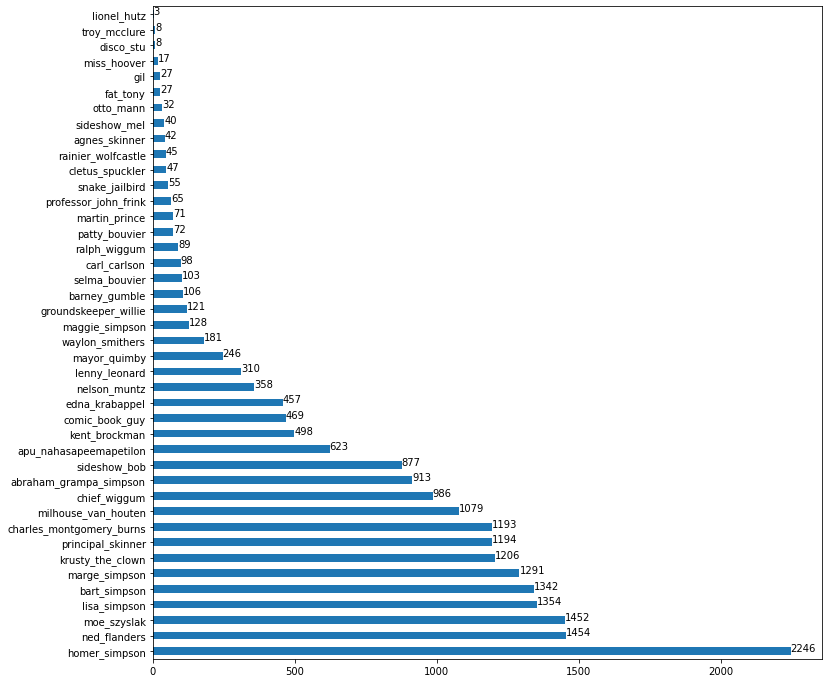

In [ ]:
# Посмотрим на распределение героев в выборке
classes_distribution = pd.Series(train_val_labels).value_counts()

plt.figure(figsize=(12,12))
classes_distribution.plot(kind='barh')

# Подпишем значения
for index, value in enumerate(classes_distribution):
    plt.text(value, index,
             str(f'{value}'))
plt.show()

**Взвешивание классов**

In [ ]:
# Получим наши три датасета
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(train_files, mode='val')
test_dataset = SimpsonsDataset(train_files, mode='test')


In [ ]:
# Попробуем сделать взвешивание классов
class_count = Counter(train_labels)
class_weights = torch.Tensor([len(train_labels)/c for c in pd.Series(class_count).sort_index().values]) 
        # Can't iterate over class_count because dictionary is unordered
sample_weights = [0] * len(train_dataset)
for idx, (image, label) in enumerate(tqdm_notebook(train_dataset)):
            class_weight = class_weights[label]
            sample_weights[idx] = class_weight
            
sampler_train = WeightedRandomSampler(weights=sample_weights,
                                        num_samples = len(train_dataset), replacement=True)  

  0%|          | 0/15699 [00:00<?, ?it/s]

In [ ]:
# Получим наши три даталоадера
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler_train, num_workers=2) # в тренировочный лоадер включаем веса 
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

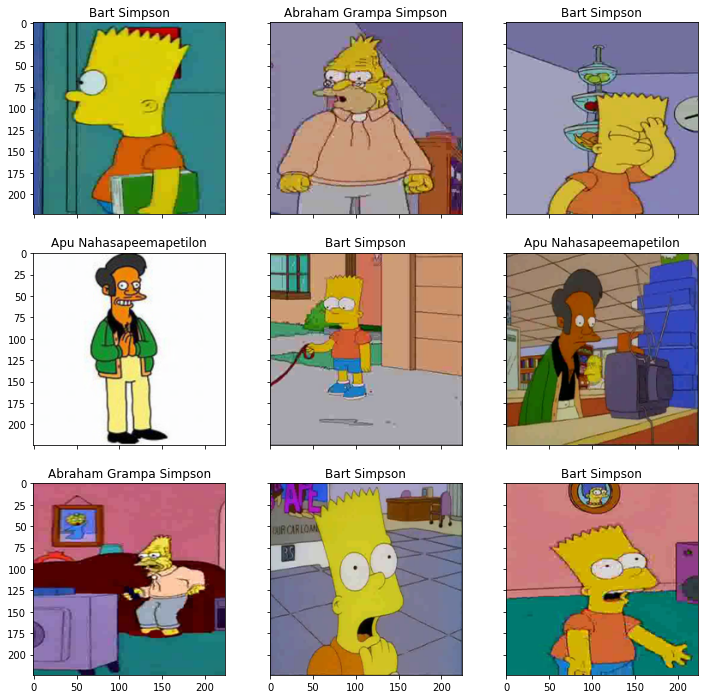

In [ ]:
# Посмотрим на изображения валидационного датасета
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,2000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

* Данные готовы для обучения.

### Обучение модели

* Создадим все необходимые функции для обучения и валидации.

In [ ]:
# Функция для тренировки
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in tqdm_notebook(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    
    
    scheduler.step()    
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc


# Функция для валидации
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in tqdm_notebook(val_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc






# Функция для агрегирования результатов обучения и валидации
def train(train_files, val_files, model, epochs, batch_size, scheduler, opt, criterion):   #(train_files, val_files, model, epochs, batch_size, ):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler_train, num_workers=2) # в тренировочный лоадер включаем веса   
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in tqdm_notebook(range(epochs)):
            train_loss, train_acc = fit_epoch(model, train_dataloader, criterion, opt, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_dataloader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
# Loading the model Resnet18
model_resnet = models.resnet18(pretrained=True).to(DEVICE)

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features   = 2048
num_classes = len(classes_distribution)    
# Changing the Classifier
model_resnet.classifier = nn.Linear(num_features, num_classes)

# Лосс
criterion = nn.CrossEntropyLoss() #criterion weight=class_weights_loss
# Оптимайзер
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=0.01)   #optim.Adam(model_eff.parameters(), lr=1e-4, amsgrad=True)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)# torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3) #lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.5)    #lr_scheduler.ReduceLRO

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
%%time
# Moving the model to device
model_resnet.to(DEVICE)  

for param in model_resnet.parameters(): # Разморозим все обучающиеся слои
    param.requires_grad = True 

# Обучим модель    
history = train(train_dataset, val_dataset, model=model_resnet, criterion=criterion, epochs=10, batch_size=batch_size, opt=optimizer, scheduler=scheduler)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

loss 0.9238555489861496


  0%|          | 0/491 [00:00<?, ?it/s]

epoch:  10%|█         | 1/10 [03:49<34:28, 229.82s/it]


Epoch 001 train_loss: 0.9239     val_loss 0.2331 train_acc 0.8537 val_acc 0.9520


  0%|          | 0/491 [00:00<?, ?it/s]

loss 0.2568165416207516


  0%|          | 0/491 [00:00<?, ?it/s]

epoch:  20%|██        | 2/10 [07:33<30:10, 226.27s/it]


Epoch 002 train_loss: 0.2568     val_loss 0.3407 train_acc 0.9352 val_acc 0.9030


  0%|          | 0/491 [00:00<?, ?it/s]

loss 0.13755767763744706


  0%|          | 0/491 [00:00<?, ?it/s]

epoch:  30%|███       | 3/10 [11:13<26:02, 223.19s/it]


Epoch 003 train_loss: 0.1376     val_loss 0.3167 train_acc 0.9653 val_acc 0.9093


  0%|          | 0/491 [00:00<?, ?it/s]

loss 0.145035438078214


  0%|          | 0/491 [00:00<?, ?it/s]

epoch:  40%|████      | 4/10 [14:54<22:13, 222.30s/it]


Epoch 004 train_loss: 0.1450     val_loss 0.1868 train_acc 0.9634 val_acc 0.9531


  0%|          | 0/491 [00:00<?, ?it/s]

loss 0.1539108329628469


  0%|          | 0/491 [00:00<?, ?it/s]

epoch:  50%|█████     | 5/10 [18:35<18:29, 221.88s/it]


Epoch 005 train_loss: 0.1539     val_loss 0.2962 train_acc 0.9614 val_acc 0.9168


  0%|          | 0/491 [00:00<?, ?it/s]

loss 0.06411278706381629


  0%|          | 0/491 [00:00<?, ?it/s]

epoch:  60%|██████    | 6/10 [22:16<14:46, 221.59s/it]


Epoch 006 train_loss: 0.0641     val_loss 0.1345 train_acc 0.9838 val_acc 0.9651


  0%|          | 0/491 [00:00<?, ?it/s]

loss 0.10382169664392077


  0%|          | 0/491 [00:00<?, ?it/s]

epoch:  70%|███████   | 7/10 [25:57<11:04, 221.60s/it]


Epoch 007 train_loss: 0.1038     val_loss 0.1342 train_acc 0.9732 val_acc 0.9662


  0%|          | 0/491 [00:00<?, ?it/s]

loss 0.09112384609526393


  0%|          | 0/491 [00:00<?, ?it/s]

epoch:  80%|████████  | 8/10 [29:37<07:21, 220.89s/it]


Epoch 008 train_loss: 0.0911     val_loss 0.2965 train_acc 0.9773 val_acc 0.9178


  0%|          | 0/491 [00:00<?, ?it/s]

loss 0.12966501264217076


  0%|          | 0/491 [00:00<?, ?it/s]

epoch:  90%|█████████ | 9/10 [33:14<03:39, 219.70s/it]


Epoch 009 train_loss: 0.1297     val_loss 0.2199 train_acc 0.9670 val_acc 0.9419


  0%|          | 0/491 [00:00<?, ?it/s]

loss 0.12205373757600754


  0%|          | 0/491 [00:00<?, ?it/s]

epoch: 100%|██████████| 10/10 [36:53<00:00, 221.36s/it]


Epoch 010 train_loss: 0.1221     val_loss 0.1745 train_acc 0.9697 val_acc 0.9554
CPU times: user 5min 53s, sys: 1min 14s, total: 7min 8s
Wall time: 36min 53s


### Оценка качества модели

In [ ]:
# Сохраним предсказания модели
loss, acc, val_loss, val_acc = zip(*history)
val_acc = torch.stack(list(val_acc), dim=0).cpu().numpy()

In [ ]:
torch.save(model_resnet.state_dict(), 'models_resnet_weights.h5')

In [ ]:
torch.save(model_resnet, 'models_resnet.h5')

In [ ]:
#model.load_state_dict(torch.load('models_resnet.pth')) # загрузим модель

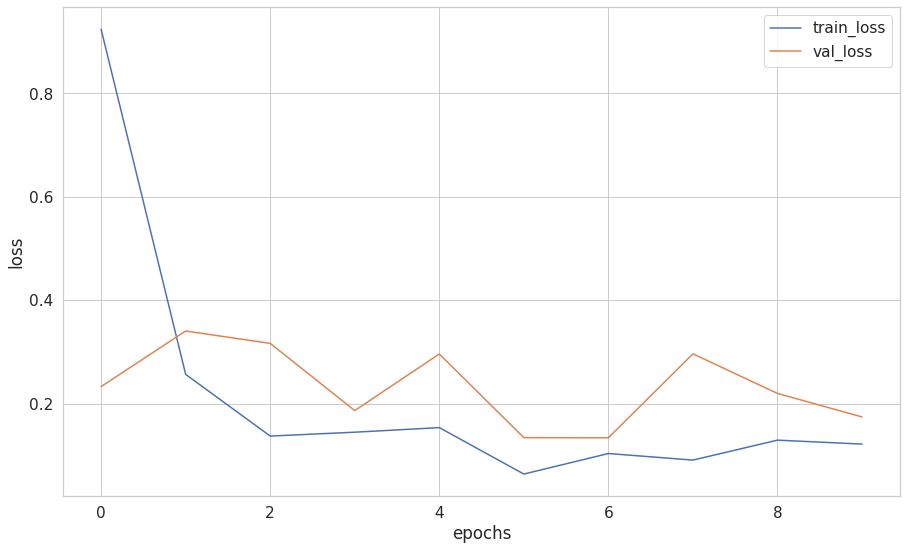

In [ ]:
# Построим график лосса при обучении и валидации
sns.set(style="whitegrid", font_scale=1.4) # font_scale = 140%
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

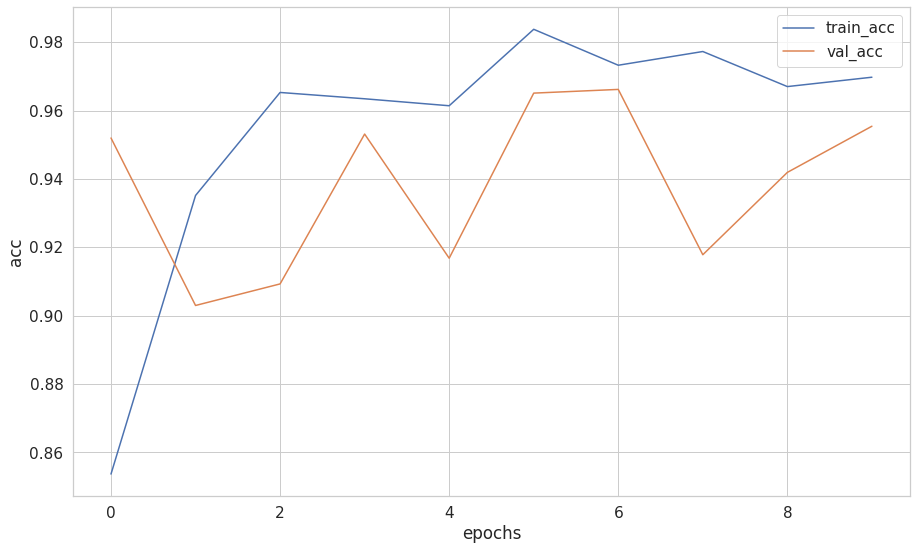

In [ ]:
# Построим график точности при обучении и валидации
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [ ]:
# Функция для предсказания классов
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
# Функция для предсказания одной картинки
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
# Создадим функцию для оценки F1
def F1_score(model, val_dataset):
    
    # Отберем случайных персонажей из валидационной выборки
    random_characters = int(np.random.uniform(0,2000))
    ex_img, true_label = val_dataset[random_characters]
    probs_im = predict_one_sample(model_resnet, ex_img.unsqueeze(0))
    
    idxs = list(map(int, np.random.uniform(0,2000, 20)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

    # Получим предсказания
    probs_ims = predict(model_resnet, imgs)

    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

    y_pred = np.argmax(probs_ims,-1)

    actual_labels = [val_dataset[id][1] for id in idxs]

    preds_class = [label_encoder.classes_[i] for i in y_pred]

    pred_val = list(np.argmax(probs_ims, axis=1))
    
    return f1_score(actual_labels, pred_val, average='micro')


In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
%%time
# Получим оценку F1   
F1_score(model_resnet, val_dataset)

CPU times: user 475 ms, sys: 9.08 ms, total: 484 ms
Wall time: 510 ms


0.9500000000000001

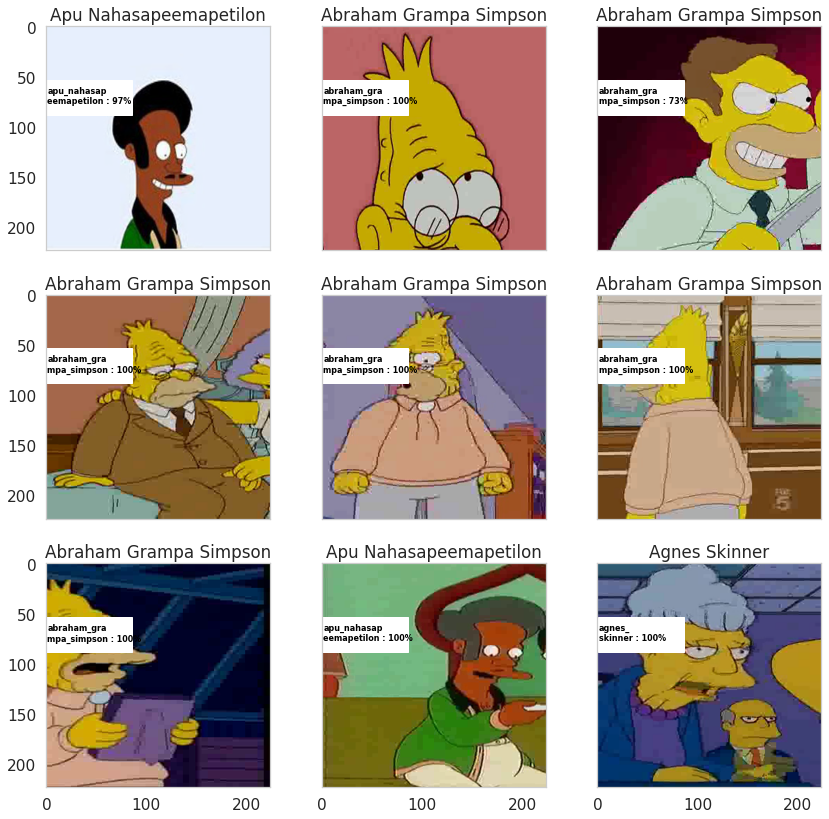

In [ ]:
# Построим на предсказания рандомных изображений из валидационной выборки
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(14, 14), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_resnet, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submission

In [ ]:
# Получим предсказания на тестовой выборке
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
probs = predict(model_resnet, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
# Создадим таблицу для результатов по тестовой выборке
sample_submission = pd.read_csv('/kaggle/input/journey-springfield/sample_submission.csv') # with low baseline accuracy
submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds}).sort_values('Id') # my final result
submission.to_csv('./mysubmission.csv', index=False)
display(sample_submission.head())
print()
display(submission.head())

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
